## Importing libraries

In [9]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Reading data

In [10]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)


## Getting the training set and the test set

In [11]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [12]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [13]:
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Zamroź warstwy

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [14]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 18128.0410 - mae: 100.8970 - val_loss: 8416.9023 - val_mae: 73.0542
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 6971.1396 - mae: 66.6693 - val_loss: 7076.4453 - val_mae: 67.7822
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 4654.3164 - mae: 46.8448 - val_loss: 5610.4907 - val_mae: 57.9375
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 3334.0259 - mae: 39.5040 - val_loss: 4231.4048 - val_mae: 43.9951
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 2519.2241 - mae: 34.6576 - val_loss: 3843.2161 - val_mae: 38.2684
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 2656.8872 - mae: 36.3580 - val_loss: 3449.3291 - val_mae: 36.1760
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 2361.2412 - mae: 33.9667 - val_loss: 2986.5862 - val_mae: 32.9971
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - loss: 1925.4734 - mae: 31.1612 - val_loss: 2959.3484 - val_mae: 32.0491
Epoch 

## Training curves visualisation

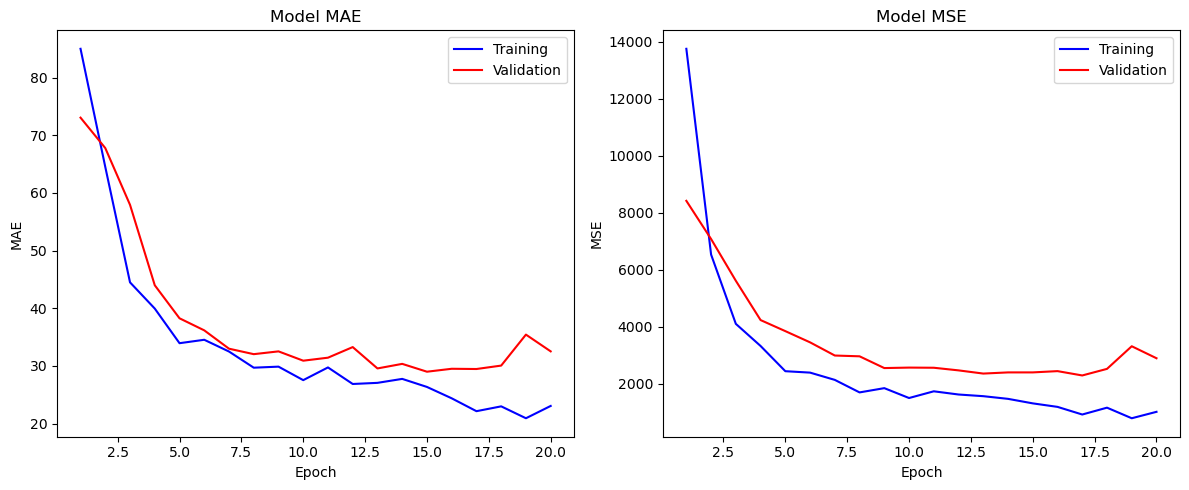

In [15]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


## Making predictions

In [16]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step  


In [17]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 23.  23.]
 [145. 181.]
 [136. 157.]
 [ 42.  37.]
 [ 55.  70.]
 [ 56.  57.]
 [ 44.  44.]
 [248. 227.]
 [223. 165.]
 [282. 476.]
 [117. 139.]
 [243. 316.]
 [174. 164.]
 [114. 110.]
 [ 40.  20.]
 [139. 131.]
 [ 54.  48.]
 [135. 183.]
 [147. 101.]
 [157. 204.]
 [ 44.  40.]
 [103. 143.]
 [123. 146.]
 [271. 513.]
 [ 78.  70.]
 [108. 175.]
 [ 31.  51.]
 [ 76.  55.]
 [ 71.  67.]
 [ 35.  72.]
 [ 57.  56.]
 [156. 165.]
 [ 31.  32.]
 [157. 149.]
 [ 51.  48.]
 [ 95.  80.]
 [ 80. 117.]
 [ 82. 162.]
 [145. 137.]
 [ 95. 120.]
 [ 49.  72.]
 [119. 122.]
 [126. 198.]
 [ 98. 133.]
 [105. 147.]
 [ 40.  29.]
 [ 53.  70.]
 [ 27.  35.]
 [104.  24.]
 [207. 251.]
 [ 49.  59.]
 [110.  67.]
 [ 31.  61.]
 [241. 248.]
 [186. 252.]
 [197. 147.]
 [ 55.  57.]
 [ 92. 121.]
 [ 62.  47.]
 [308. 505.]
 [251. 297.]
 [241. 465.]
 [142. 167.]
 [ 29.  43.]
 [ 27.  46.]
 [125.  91.]
 [232. 263.]
 [120.  92.]
 [ 64. 117.]
 [ 44.  48.]
 [ 38.  54.]
 [100.  73.]
 [ 93. 122.]
 [ 49.  60.]
 [224. 170.]
 [126. 167.]
 [ 47.  57.]

## R2 score

In [18]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.6804010272026062